In [1]:
from stock_env.algos.agent import Agent
from stock_env.envs import *
from stock_env.common.common_utils import open_config
from stock_env.common.env_utils import make_vec_env
import torch as th
from stock_env.common.common_utils import create_performance, plot_trade_log_v2
from stock_env.common.evaluation import play_an_episode, evaluate_agent
from stock_env.common.common_utils import open_config
import seaborn as sns
sns.set()
import plotly.graph_objects as go
import os
from empyrical import (
    annual_return,
    cum_returns_final,
    annual_volatility,
    sharpe_ratio,
    max_drawdown,
    value_at_risk,
    roll_max_drawdown
)
def buy_and_hold_plot(df, algo_name, init_cash=1000000):
    import vectorbt as vbt
    
    # portfolio value from hodling
    df["pv_from_holding"] = vbt.Portfolio.from_holding(
        df.close, init_cash=init_cash
    ).value()
    df = df.set_index("time")
    ticker = df["ticker_x"].unique()[0]
    
    fig = go.Figure()
    fig.update_layout(width=800, height=500)
    fig.update_layout(title=f"Buy-n-Hold Comparision, Ticker: {ticker}", title_x=0.5)
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Portfolio Value ($)")

    df["portfolio_value"].vbt.plot_against(
        other=df["pv_from_holding"],
        other_trace_kwargs=dict(
            line=dict(width=2, color="dimgray"), mode="lines", name="Buy-n-Hold"
        ),
        trace_kwargs=dict(
            mode="lines+markers",
            line=dict(width=3, color="lightslategray"),
            name=algo_name,
        ),
        pos_trace_kwargs=dict(fillcolor="palegreen"),
        neg_trace_kwargs=dict(fillcolor="salmon"),
        fig=fig,
    )
    fig.show()

In [17]:
task = "HPG"
algo = "ppo_adapt"
# algo = "ppo"


# process params
env_id = "VNALL-v0"
config_path = f"../configs/{algo}.yaml"
_ticker = f"_{task[0]}"
# ppo_model_folder = f"../model/evaluation{_ticker}/"
# ppo_adapt_model_folder = f"../model/adapt_evaluation{_ticker}/"
ppo_model_folder = f"../model/evaluation/"
ppo_adapt_model_folder = f"../model/adapt_evaluation_M/"

ppo_files = os.listdir(ppo_model_folder)
ppo_adapt_files = os.listdir(ppo_adapt_model_folder)

ppo_models, ppo_adapt_models = {}, {}
for filename in ppo_files:
    if filename.startswith("ppo_"):
        ticker = filename.split("_")[-3]
        ppo_models.update({ticker: filename})

for filename in ppo_adapt_files:
    if filename.startswith("ppo_adapt_"):
        ticker = filename.split("_")[-3]
        ppo_adapt_models.update({ticker: filename})

In [18]:
model_type = ppo_models if algo == 'ppo' else ppo_adapt_models
_model_folder = ppo_model_folder if algo == 'ppo' else ppo_adapt_model_folder
_model_path = f"{_model_folder}{model_type[task]}"
print(_model_path)
# setting up
args = open_config(config_path, env_id=env_id)
envs = make_vec_env(env_id, num_envs=1, task=task)
agent = Agent(envs, hiddens=args.hiddens)
random_agent = Agent(envs, hiddens=args.hiddens)
# agent.load_state_dict(th.load(_model_path))
agent.load_state_dict(th.load("../model/adapt_evaluation_M/ppo_adapt_HPG_20230302_124226.pth"))

../model/adapt_evaluation_M/ppo_adapt_HPG_20230302_124226.pth


<All keys matched successfully>

In [19]:
eval_envs = make_vec_env(env_id, num_envs=args.num_envs, task=task)
eval_envs.train(False)
mean, std = evaluate_agent(agent=random_agent, envs=eval_envs, n_eval_episodes=args.n_eval_episodes)
print(f"Mean reward: {mean:.2f} +/- {std: .2f}")
mean, std = evaluate_agent(agent=agent, envs=eval_envs, n_eval_episodes=args.n_eval_episodes)
print(f"Mean reward: {mean:.2f} +/- {std: .2f}")

Mean reward: -3.81 +/-  5.14
Mean reward: 9.71 +/-  11.17


Ticker: HPG, from date 2019-11-12 00:00:00 to date 2020-11-10 00:00:00

    Annual return     :  11.16%
    Cumulative return :  11.06%
    Sharpe ratio      :  1.31
    Maximum Drawdown  : -11.34%
    Annual Volatility :  8.40%
    Value-At-Risk     :  nan%
    

    Annual return     :  69.62%
    Cumulative return :  68.91%
    Sharpe ratio      :  1.70
    Maximum Drawdown  : -38.40%
    Annual Volatility :  34.84%
    Value-At-Risk     :  nan%
    


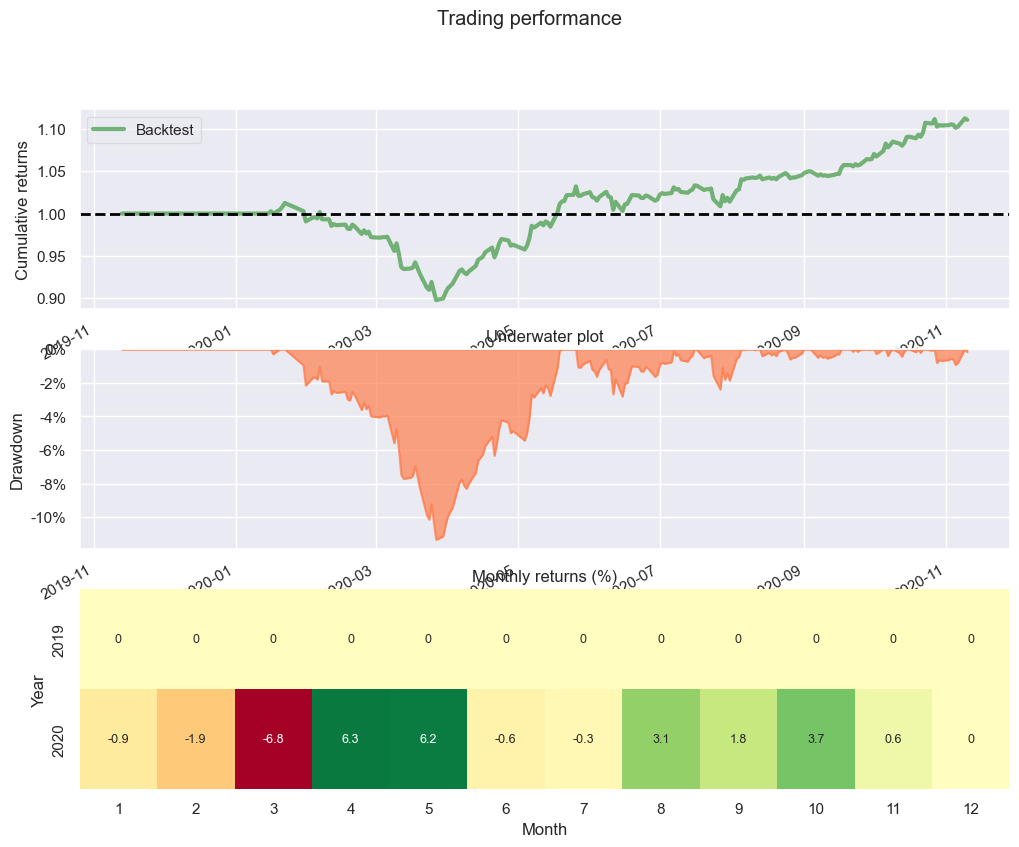

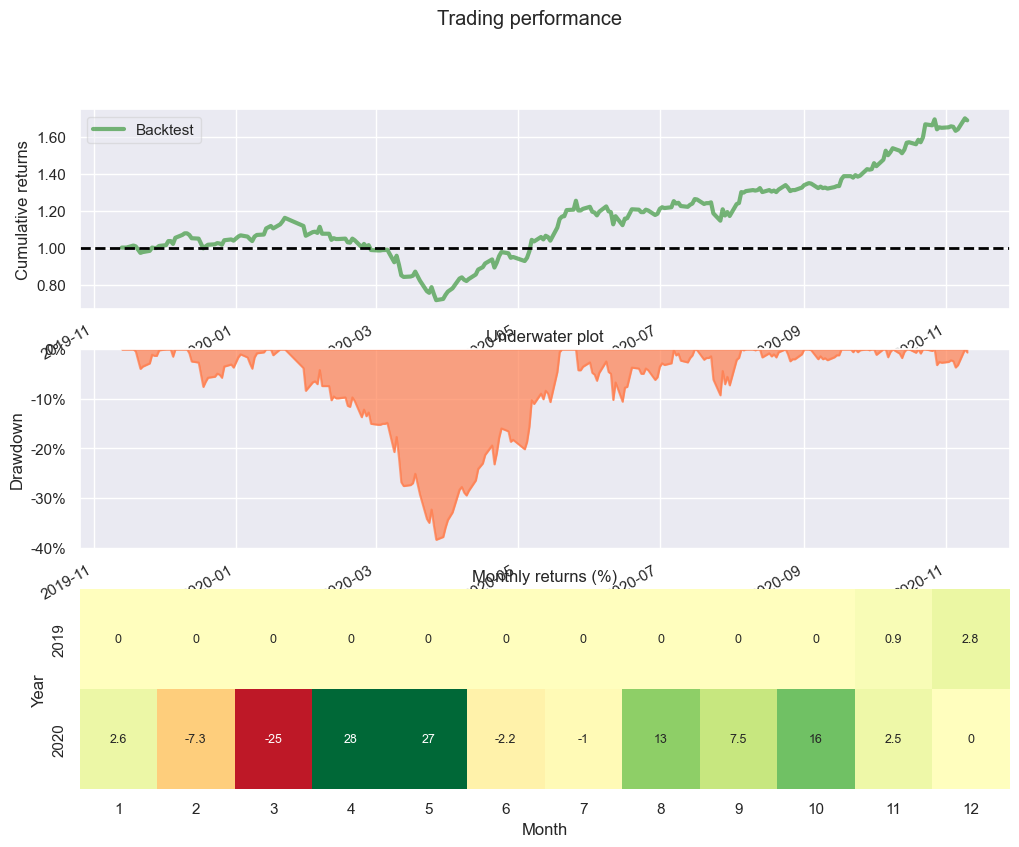

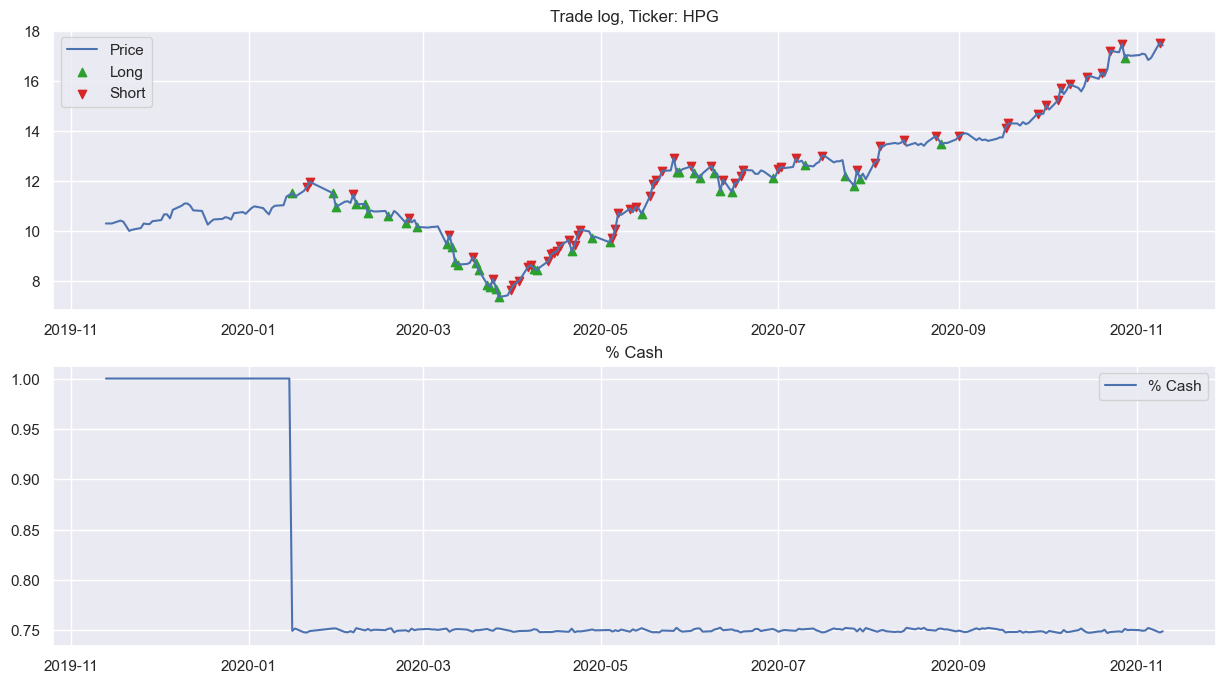

In [26]:
# _agent = random_agent
_agent = agent

# evaluate
envs.train(False)
info = play_an_episode(_agent, envs)
df = info["final_info"][0]["final_history"]
returns = df.set_index("time")["portfolio_value"].pct_change()
stock_returns = df.set_index("time")["close_price"].pct_change()
results = create_performance(returns)
_ = create_performance(stock_returns)
plot_trade_log_v2(df)

buy_and_hold_plot(df, "PPO_adapt", init_cash=envs.envs[0].init_cash)